In [1]:
%load_ext autoreload
%autoreload 2
# Sanity check on implementation of 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import time
# Set a limit on the memory usage of the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-05-28 09:35:48.516843: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 09:35:48.516885: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-28 09:35:48.516895: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 09:35:48.526593: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Ensure that log prob calculations are the same as tfp implementation & faster

In [3]:
# Define your array (as a TensorFlow tensor)
n_rows = 1000 # i.e., number of voxels 
n_cols = 200 # i.e., number of samples in timeseries
num_iterations = 100
data = tf.constant(np.random.rand(n_rows, n_cols), dtype=tf.float32)
scale_values = tf.constant(np.random.rand(n_rows, 1), dtype=tf.float32)
dof_values = tf.constant(np.random.rand(n_rows, 1), dtype=tf.float32)

#### testing calculate_log_prob_gauss_loc0

In [4]:


from braincoder.utils.math import calculate_log_prob_gauss_loc0
for device in ['GPU', 'CPU']:
    print(f'Trying with {device}')
    with tf.device(f'/{device}:0'):
        # Timing the custom log probability calculation
        calculate_log_prob_gauss_loc0(data, scale_values) # Compile / warm up first
        start_time = time.time()
        for _ in range(num_iterations):
            calculate_log_prob_gauss_loc0(data, scale_values)  # Now correctly broadcasted
        time_custom = time.time() - start_time
        output_custom = calculate_log_prob_gauss_loc0(data, scale_values)
        # Timing the TFP log probability calculation
        start_time = time.time()
        for _ in range(num_iterations):
            normal_dist = tfp.distributions.Normal(loc=0.0, scale=scale_values)  # Correct shape
            normal_dist.log_prob(data)  # Correct shape
        time_tfd = time.time() - start_time
        output_tfd = normal_dist.log_prob(data)
        # Print the results
        print(f"Custom log probability calculation time over {num_iterations} iterations: {time_custom:.6f} seconds")
        print(f"TFP log probability calculation time over {num_iterations} iterations: {time_tfd:.6f} seconds")
        print(f"Custom method is  {time_tfd/time_custom:.3f} x faster")
        print(f"     tfd,        custom")
        for i1 in range(3):
            for i2 in range(3):
                print(f'{output_tfd[i1,i2]:10.3f}, {output_custom[i1,i2]:10.3f}')


Trying with GPU
Custom log probability calculation time over 100 iterations: 0.053474 seconds
TFP log probability calculation time over 100 iterations: 0.613541 seconds
Custom method is  11.474 x faster
     tfd,        custom
    -4.382,     -4.382
     0.057,      0.057
    -6.501,     -6.501
    -0.401,     -0.401
    -1.321,     -1.321
    -0.620,     -0.620
   -15.529,    -15.529
     1.411,      1.411
     1.297,      1.297
Trying with CPU
Custom log probability calculation time over 100 iterations: 0.089566 seconds
TFP log probability calculation time over 100 iterations: 0.183373 seconds
Custom method is  2.047 x faster
     tfd,        custom
    -4.382,     -4.382
     0.057,      0.057
    -6.501,     -6.501
    -0.401,     -0.401
    -1.321,     -1.321
    -0.620,     -0.620
   -15.529,    -15.529
     1.411,      1.411
     1.297,      1.297


#### Testing calculate_log_prob_t

In [5]:
from braincoder.utils.math import calculate_log_prob_t
for device in ['GPU', 'CPU']:
    print(f'Trying with {device}')
    with tf.device(f'/{device}:0'):
        # Timing the custom log probability calculation
        calculate_log_prob_t(data, scale_values, dof_values) # warm up first
        start_time = time.time()
        for _ in range(num_iterations):
            calculate_log_prob_t(data, scale_values, dof_values)  # Now correctly broadcasted
        time_custom = time.time() - start_time
        output_custom = calculate_log_prob_t(data, scale_values, dof_values)

        # Timing the TFP log probability calculation
        start_time = time.time()
        for _ in range(num_iterations):
            t_dist = tfp.distributions.StudentT(df=dof_values, loc=0.0, scale=scale_values)  # Correct shape
            t_dist.log_prob(data)  # Correct shape
        time_tfd = time.time() - start_time
        output_tfd = t_dist.log_prob(data)

        # Print the results
        print(f"Custom log probability calculation time over {num_iterations} iterations: {time_custom:.6f} seconds")
        print(f"TFP log probability calculation time over {num_iterations} iterations: {time_tfd:.6f} seconds")
        print(f"Custom method is  {time_tfd/time_custom:.3f} x faster")
        print(f"     tfd,        custom")
        for i1 in range(3):
            for i2 in range(3):
                print(f'{output_tfd[i1,i2]:10.3f}, {output_custom[i1,i2]:10.3f}')


Trying with GPU
Custom log probability calculation time over 100 iterations: 0.239722 seconds
TFP log probability calculation time over 100 iterations: 2.806433 seconds
Custom method is  11.707 x faster
     tfd,        custom
    -2.147,     -2.147
    -0.486,     -0.486
    -2.440,     -2.440
    -0.873,     -0.873
    -2.042,     -2.042
    -1.367,     -1.367
    -2.258,     -2.258
     0.813,      0.813
     0.422,      0.422
Trying with CPU
Custom log probability calculation time over 100 iterations: 0.300222 seconds
TFP log probability calculation time over 100 iterations: 0.647883 seconds
Custom method is  2.158 x faster
     tfd,        custom
    -2.147,     -2.147
    -0.486,     -0.486
    -2.440,     -2.440
    -0.873,     -0.873
    -2.042,     -2.042
    -1.367,     -1.367
    -2.258,     -2.258
     0.813,      0.813
     0.422,      0.422


# Check GP dists
-> not functional for now - as I have rolled back the "prec" method. I may bring it back at a later date

In [9]:
# import tensorflow as tf
# import tensorflow_probability as tfp
# # Force CPU

# import math
# import time
# import numpy as np

# from braincoder.bprf_mcmc import GPdists, mds_embedding, compute_euclidean_distance_matrix
# tfd = tfp.distributions

# for device in ['CPU']: #, 'GPU']:
#     print(f'\n\n\n\n\nTrying with {device}')
#     with tf.device(f'/{device}:0'):
#         # Create a dummy symmetric distance matrix.
#         n_vx = 500
#         rand = tf.random.uniform((n_vx, n_vx), minval=0, maxval=1, dtype=tf.float64)
#         dists = (rand + tf.transpose(rand)) / 2.0
#         dists = dists - tf.linalg.diag(tf.linalg.diag_part(dists))

#         # Set hyperparameters.
#         gp_variance = tf.constant(1.0, dtype=tf.float32)
#         gp_lengthscale = tf.constant(1.0, dtype=tf.float32)
#         gp_mean = tf.constant(0.0, dtype=tf.float32)
#         gp_nugget = tf.constant(0.1, dtype=tf.float32)

#         # Instantiate GPdists with fixed hyperparameters.
#         gp_fixed = GPdists(
#             dists,
#             fixed_params='fixed_all',
#             full_norm=True, 
#             gp_variance=gp_variance,
#             gp_lengthscale=gp_lengthscale,
#             gp_mean=gp_mean,
#             gp_nugget=gp_nugget,
#             psd_control='euclidean',
#             dists_dtype=tf.float64, # for cholesky... 
#             kernel='RBF',
#         )

#         # For comparison, get the covariance matrix computed by GPdists.
#         cov_matrix = gp_fixed.cov_matrix

#         # Create a random parameter vector (matching the number of vertices).
#         parameter = tf.random.normal([n_vx], dtype=tf.float32)

#         # Warm-up (to compile tf.function graphs)
#         _ = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
#         # _ = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)

#         # Timing the fixed TF method.
#         start_time = time.time()
#         for _ in range(1000):  # Adjust the number of iterations as needed.
#             _ = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
#         time_fixed_tf = time.time() - start_time

#         # Timing the fixed precision method.
#         start_time = time.time()
#         for _ in range(1000):  # Adjust the number of iterations as needed.
#             _ = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
#         time_fixed_prec = time.time() - start_time

#         print(f"Timing for Fixed TF method: {time_fixed_tf:.6f} seconds")
#         print(f"Timing for Fixed Precision method: {time_fixed_prec:.6f} seconds")
#         print(f"Fixed Precision is  {time_fixed_tf/time_fixed_prec:.3f} x faster")
#         # Compute log probability using the fixed TF method.
#         log_prob_fixed_tf = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)

#         # Compute log probability using the fixed precision method.
#         log_prob_fixed_prec = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)

#         print("Log probability (Fixed TF):       ", log_prob_fixed_tf.numpy())
#         print("Log probability (Fixed Precision):  ", log_prob_fixed_prec.numpy())

In [ ]:
# import tensorflow as tf
# import tensorflow_probability as tfp
# import math
# import time
# import numpy as np

# from braincoder.bprf_mcmc import GPdists, mds_embedding, compute_euclidean_distance_matrix
# tfd = tfp.distributions
# full_norm = True
# # ------------------------------
# # Setup: create a dummy distance matrix.
# # ------------------------------
# n_vx = 50
# rand = tf.random.uniform((n_vx, n_vx), minval=0, maxval=1, dtype=tf.float64)
# dists = (rand + tf.transpose(rand)) / 2.0
# dists = dists - tf.linalg.diag(tf.linalg.diag_part(dists))

# # ------------------------------
# # Hyperparameters
# # ------------------------------
# # Note: GPdists expects the distance tensor to be tf.float64 (for Cholesky) so we set that,
# # but the parameter vector itself is in tf.float32.
# gp_variance = tf.constant(1.0, dtype=tf.float32)
# gp_lengthscale = tf.constant(1.0, dtype=tf.float32)
# gp_mean = tf.constant(0.0, dtype=tf.float32)
# gp_nugget = tf.constant(0.1, dtype=tf.float32)

# # ------------------------------
# # Instantiate GPdists: fixed and unfixed versions.
# # ------------------------------
# # Fixed instance: precomputes covariance matrix, Cholesky, and precision.
# gp_fixed = GPdists(
#     dists,
#     fixed_params=True,
#     full_norm=full_norm,  # Option for full normalization in precision-based log_prob.
#     gp_variance=gp_variance,
#     gp_lengthscale=gp_lengthscale,z
#     gp_mean=gp_mean,
#     gp_nugget=gp_nugget,
#     psd_control='euclidean',
#     dists_dtype=tf.float64,  # ensure Cholesky and covariance are computed in float64
#     kernel='RBF',
#     log_prob_method='precision',  # choose 'precision' for testing the new option.
# )

# # Unfixed instance: recomputes covariance every time.
# gp_unfixed = GPdists(
#     dists,
#     fixed_params=False,
#     full_norm=full_norm,  # will be passed to unfixed precision method
#     gp_variance=gp_variance,
#     gp_lengthscale=gp_lengthscale,
#     gp_mean=gp_mean,
#     gp_nugget=gp_nugget,
#     psd_control='euclidean',
#     dists_dtype=tf.float64,
#     kernel='RBF',
#     log_prob_method='precision',
# )

# # ------------------------------
# # Create a random parameter vector (matches number of vertices).
# # ------------------------------
# parameter = tf.random.normal([n_vx], dtype=tf.float32)

# # Warm-up (compile tf.function graphs)
# _ = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
# _ = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
# _ = gp_unfixed._return_log_prob_unfixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
# _ = gp_unfixed._return_log_prob_unfixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)

# # ------------------------------
# # Helper function to time method calls.
# # ------------------------------
# def time_method(method, instance, param, iterations=5000, **kwargs):
#     # Warm-up one call outside timing
#     _ = method(param, gp_lengthscale, gp_variance, gp_mean, gp_nugget, **kwargs)
#     start = time.time()
#     for _ in range(iterations):
#         _ = method(param, gp_lengthscale, gp_variance, gp_mean, gp_nugget, **kwargs)
#     return (time.time() - start) / iterations

# # ------------------------------
# # Devices to test (CPU and GPU if available)
# # ------------------------------
# devices = ['/cpu:0']
# if tf.config.list_physical_devices('GPU'):
#     devices.append('/gpu:0')

# # ------------------------------
# # Run tests on each device.
# # ------------------------------
# for device in devices:
#     print("\nTesting on device:", device)
#     with tf.device(device):
#         # Fixed methods.
#         t_fixed_tf = time_method(gp_fixed._return_log_prob_fixed_tf, gp_fixed, parameter)
#         t_fixed_prec = time_method(gp_fixed._return_log_prob_fixed_prec, gp_fixed, parameter)
        
#         # Unfixed methods.
#         t_unfixed_tf = time_method(gp_unfixed._return_log_prob_unfixed_tf, gp_unfixed, parameter)
#         t_unfixed_prec = time_method(gp_unfixed._return_log_prob_unfixed_prec, gp_unfixed, parameter)
        
#         # Compute log probabilities (for a single call).
#         lp_fixed_tf = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
#         lp_fixed_prec = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
#         lp_unfixed_tf = gp_unfixed._return_log_prob_unfixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
#         lp_unfixed_prec = gp_unfixed._return_log_prob_unfixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        
#         print("Log probability (Fixed TF):        ", lp_fixed_tf.numpy())
#         print("Log probability (Fixed Prec):        ", lp_fixed_prec.numpy())
#         print("Log probability (Unfixed TF):        ", lp_unfixed_tf.numpy())
#         print("Log probability (Unfixed Prec):      ", lp_unfixed_prec.numpy())
        
#         print("\nAverage runtime per call:")
#         print("  Fixed TF method:      {:.6f} sec".format(t_fixed_tf))
#         print("  Fixed Precision method: {:.6f} sec".format(t_fixed_prec))
#         print("  Unfixed TF method:    {:.6f} sec".format(t_unfixed_tf))
#         print("  Unfixed Precision method: {:.6f} sec".format(t_unfixed_prec))


In [ ]:
# import tensorflow as tf
# import tensorflow_probability as tfp
# import math
# import time
# import numpy as np

# from braincoder.bprf_mcmc import GPdists, mds_embedding, compute_euclidean_distance_matrix
# tfd = tfp.distributions
# full_norm = False
# # ------------------------------
# # Setup: create a dummy distance matrix.
# # ------------------------------
# n_vx = 50
# rand = tf.random.uniform((n_vx, n_vx), minval=0, maxval=1, dtype=tf.float64)
# dists = (rand + tf.transpose(rand)) / 2.0
# dists = dists - tf.linalg.diag(tf.linalg.diag_part(dists))

# # ------------------------------
# # Hyperparameters
# # ------------------------------
# # Note: GPdists expects the distance tensor to be tf.float64 (for Cholesky) so we set that,
# # but the parameter vector itself is in tf.float32.
# gp_variance = tf.constant(1.0, dtype=tf.float32)
# gp_lengthscale = tf.constant(1.0, dtype=tf.float32)
# gp_mean = tf.constant(0.0, dtype=tf.float32)
# gp_nugget = tf.constant(0.1, dtype=tf.float32)

# # ------------------------------
# # Instantiate GPdists: fixed and unfixed versions.
# # ------------------------------
# # Fixed instance: precomputes covariance matrix, Cholesky, and precision.
# gp_fixed = GPdists(
#     dists,
#     fixed_params=True,
#     full_norm=True,  # Option for full normalization in precision-based log_prob.
#     gp_variance=gp_variance,
#     gp_lengthscale=gp_lengthscale,
#     gp_mean=gp_mean,
#     gp_nugget=gp_nugget,
#     psd_control='euclidean',
#     dists_dtype=tf.float64,  # ensure Cholesky and covariance are computed in float64
#     kernel='RBF',
#     log_prob_method='precision',  # choose 'precision' for testing the new option.
# )

# # Unfixed instance: recomputes covariance every time.
# gp_unfixed = GPdists(
#     dists,
#     fixed_params=False,
#     full_norm=True,  # will be passed to unfixed precision method
#     gp_variance=gp_variance,
#     gp_lengthscale=gp_lengthscale,
#     gp_mean=gp_mean,
#     gp_nugget=gp_nugget,
#     psd_control='euclidean',
#     dists_dtype=tf.float64,
#     kernel='RBF',
#     log_prob_method='precision',
# )

# # ------------------------------
# # Create a random parameter vector (matches number of vertices).
# # ------------------------------
# parameter = tf.random.normal([n_vx], dtype=tf.float32)

# # Warm-up (compile tf.function graphs)
# _ = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
# _ = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget, full_norm=True)
# _ = gp_unfixed._return_log_prob_unfixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
# _ = gp_unfixed._return_log_prob_unfixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget, full_norm=True)

# # ------------------------------
# # Helper function to time method calls.
# # ------------------------------
# def time_method(method, instance, param, iterations=100, **kwargs):
#     # Warm-up one call outside timing
#     _ = method(param, gp_lengthscale, gp_variance, gp_mean, gp_nugget, **kwargs)
#     start = time.time()
#     for _ in range(iterations):
#         _ = method(param, gp_lengthscale, gp_variance, gp_mean, gp_nugget, **kwargs)
#     return (time.time() - start) / iterations

# # ------------------------------
# # Devices to test (CPU and GPU if available)
# # ------------------------------
# devices = ['/cpu:0']
# if tf.config.list_physical_devices('GPU'):
#     devices.append('/gpu:0')

# # ------------------------------
# # Run tests on each device.
# # ------------------------------
# for device in devices:
#     print("\nTesting on device:", device)
#     with tf.device(device):
#         # Fixed methods.
#         t_fixed_tf = time_method(gp_fixed._return_log_prob_fixed_tf, gp_fixed, parameter)
#         t_fixed_prec = time_method(gp_fixed._return_log_prob_fixed_prec, gp_fixed, parameter, full_norm=True)
        
#         # Unfixed methods.
#         t_unfixed_tf = time_method(gp_unfixed._return_log_prob_unfixed_tf, gp_unfixed, parameter)
#         t_unfixed_prec = time_method(gp_unfixed._return_log_prob_unfixed_prec, gp_unfixed, parameter, full_norm=True)
        
#         # Compute log probabilities (for a single call).
#         lp_fixed_tf = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
#         lp_fixed_prec = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget, full_norm=True)
#         lp_unfixed_tf = gp_unfixed._return_log_prob_unfixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
#         lp_unfixed_prec = gp_unfixed._return_log_prob_unfixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget, full_norm=True)
        
#         print("Log probability (Fixed TF):        ", lp_fixed_tf.numpy())
#         print("Log probability (Fixed Prec):        ", lp_fixed_prec.numpy())
#         print("Log probability (Unfixed TF):        ", lp_unfixed_tf.numpy())
#         print("Log probability (Unfixed Prec):      ", lp_unfixed_prec.numpy())
        
#         print("\nAverage runtime per call:")
#         print("  Fixed TF method:      {:.6f} sec".format(t_fixed_tf))
#         print("  Fixed Precision method: {:.6f} sec".format(t_fixed_prec))
#         print("  Unfixed TF method:    {:.6f} sec".format(t_unfixed_tf))
#         print("  Unfixed Precision method: {:.6f} sec".format(t_unfixed_prec))


# Test multivariate normal implementations

In [12]:
import tensorflow as tf

import tensorflow_probability as tfp
import math
import numpy as np

tfd = tfp.distributions

with tf.device(f'/CPU:0'):
    # Generate a random positive definite covariance matrix for a 5-dimensional Gaussian.
    n = 5
    # Create a random matrix and form a covariance matrix by A * A^T.
    A = tf.random.normal((n, n), dtype=tf.float64)
    cov = tf.matmul(A, A, transpose_b=True) + tf.eye(n, dtype=tf.float64)*1e-3
    mean = tf.random.normal((n,), dtype=tf.float64)
    x = tf.random.normal((n,), dtype=tf.float64)

    # 1. Log probability using TFP's MultivariateNormalFullCovariance:
    dist = tfd.MultivariateNormalFullCovariance(loc=mean, covariance_matrix=cov)
    log_prob_tfp = dist.log_prob(x)

    # 2. Log probability using the full Gaussian formula:
    #    log p(x) = -0.5 * [ n*log(2π) + log|cov| + (x-mean)^T cov^-1 (x-mean) ]
    def full_gaussian_log_prob(x, mean, cov):
        n = tf.cast(tf.shape(x)[0], cov.dtype)
        diff = x - mean
        inv_cov = tf.linalg.inv(cov)
        log_det_cov = tf.linalg.logdet(cov)
        quad_form = tf.tensordot(diff, tf.linalg.matvec(inv_cov, diff), axes=1)
        # Cast constant 2*pi to the same dtype as cov
        two_pi = tf.constant(2 * math.pi, dtype=cov.dtype)
        return -0.5 * (n * tf.math.log(two_pi) + log_det_cov + quad_form)

    log_prob_full = full_gaussian_log_prob(x, mean, cov)

    # 3. Log probability using the precision matrix directly:
    #    We use the fact that:
    #      log p(x) = 0.5 * log|Q| - 0.5 * (x-mean)^T Q (x-mean) - (n/2)*log(2π)
    #    where Q = cov^-1.
    Q = tf.linalg.inv(cov)
    log_det_Q = tf.linalg.logdet(Q)
    diff = x - mean
    quad_form_precision = tf.tensordot(diff, tf.linalg.matvec(Q, diff), axes=1)
    two_pi = tf.constant(2 * math.pi, dtype=cov.dtype)
    log_prob_precision = 0.5 * log_det_Q - 0.5 * quad_form_precision - 0.5 * tf.cast(n, cov.dtype) * tf.math.log(two_pi)

    print("Log probability (TFP):         ", log_prob_tfp.numpy())
    print("Log probability (Full formula):", log_prob_full.numpy())
    print("Log probability (Precision):   ", log_prob_precision.numpy())


Log probability (TFP):          -9.276045672411296
Log probability (Full formula): -9.276045672411229
Log probability (Precision):    -9.276045672411236


# Jacobians
-> linear case

max |difference|: 13.872515
tf.Tensor(
[-12.484748  -12.457624  -12.945479  -12.649834  -12.462858  -12.945866
 -12.621287  -12.521995  -12.939007  -12.58573   -12.5470495 -13.207197
 -12.476216  -12.593416  -12.45021   -13.872515  -12.698333  -12.879074
 -12.684998  -12.48528   -12.49528   -13.10009   -12.706998  -12.4509945
 -12.804838  -13.145547  -12.916149  -12.489368  -12.467009  -12.669823
 -12.454252  -12.928165  -12.70282   -12.456813  -13.391992  -12.469147
 -12.580645  -12.50103   -12.594704  -12.494703  -12.737508  -12.464858
 -12.5343275 -12.465458  -12.449363  -12.758532  -12.471991  -12.566587
 -13.345459  -12.590408  -12.810297  -12.790974  -12.462847  -12.476565
 -12.486916  -13.593077  -12.725537  -12.456938  -12.772919  -13.088698
 -12.628485  -12.703525  -13.073971  -12.48339   -12.73182   -12.712983
 -12.560476  -12.85977   -12.732876  -12.669877  -12.538765  -12.741715
 -12.603481  -12.81722   -12.738123  -12.44969   -13.570654  -12.468709
 -12.453623  -12.835318 

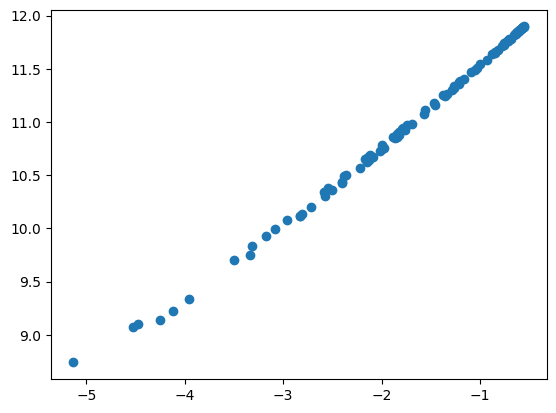

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfb = tfp.bijectors

with tf.device(f'/CPU:0'):
    # Number of independent scalars
    num_vertices = 100

    # 1) Sample unconstrained φ
    p_unconst = tf.random.normal([num_vertices])

    # 2) Define bijector 
    p_min, p_max = 0.1, 6.0
    bijector = tfb.Sigmoid(low=p_min, high=p_max)

    # 3) Prior - built in intuitive easy to understand (contrained) space
    mu0, sigma0 = 3.0, 1.0
    base_dist = tfd.Normal(loc=mu0, scale=sigma0)

    # 4) TransformedDistribution over θ
    td_prior = tfd.TransformedDistribution(
        distribution=base_dist,   # base on θ
        bijector=tfb.Invert(bijector),
    )

    p_const = bijector.forward(p_unconst)

    # OPTION [1] 
    # -> Take prior distribution, wrap it with invert 
    # -> pass them the unconstrained parameters for log prob...
    logp_td = td_prior.log_prob(p_unconst)

    # OPTION [2]
    # -> Take prior distribution 
    # -> pass it contrained values
    # -> add bijector forward log det jacobian
    logp_base = base_dist.log_prob(p_const)                              # log p_Θ(θ)
    logp_jac  = bijector.forward_log_det_jacobian(p_unconst, event_ndims=0)  # log |dθ/dφ|
    logp_manual = logp_base + logp_jac                                 # elementwise sum

    # 8) Check
    diff = logp_td - logp_manual

    print("max |difference|:", np.max(np.abs(diff.numpy())))

    plt.scatter(
        logp_td.numpy(),
        logp_manual.numpy(),
    )
    print(diff)
    # assert np.allclose(logp_td.numpy(), logp_manual.numpy(), atol=1e-6)


max |difference|: 0.0


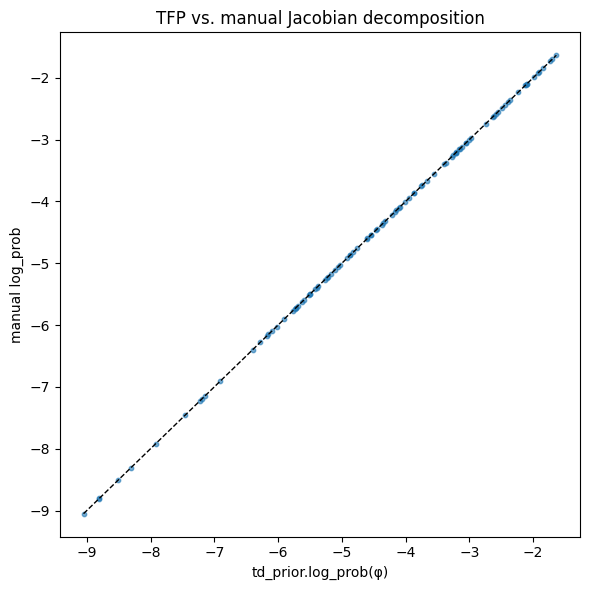

In [25]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

with tf.device(f'/CPU:0'):
    # Number of independent vectors
    num_samples = 100
    # Dimension of each vector
    D = 3

    # 1) Sample unconstrained φ ∈ ℝ^D
    phi = tf.random.normal([num_samples, D])

    # 2) Define an elementwise bijector mapping ℝ → [p_min, p_max]
    p_min, p_max = 0.1, 6.0
    sigmoid_bij = tfb.Sigmoid(low=p_min, high=p_max)

    # 3) Base prior in θ-space: Multivariate Normal with diagonal covariance
    mu0 = tf.ones([D]) * 3.0
    sigma0 = tf.ones([D]) * 1.0
    base_mvn = tfd.MultivariateNormalDiag(loc=mu0, scale_diag=sigma0)

    # 4) TransformedDistribution over φ (so that θ = sigmoid(φ) ∈ [p_min, p_max]^D)
    td_prior = tfd.TransformedDistribution(
        distribution=base_mvn,
        bijector=tfb.Invert(sigmoid_bij),
        # event_shape_override=[D],   # tells TFP that the bijector acts on a D-vector
    )

    # 5) Push φ through the forward bijector to get θ
    theta = sigmoid_bij.forward(phi)

    # 6) Compute TFP’s built-in log_prob on φ
    logp_td = td_prior.log_prob(phi)

    # 7) Manual decomposition:
    #    log p(φ) = log p_Θ(θ) + log |det dθ/dφ|
    logp_base = base_mvn.log_prob(theta)                                 # log p_Θ(θ)
    logp_jac  = sigmoid_bij.forward_log_det_jacobian(phi, event_ndims=1)  # sum over D dims
    logp_manual = logp_base + logp_jac

    # 8) Compare
    diff = logp_td - logp_manual
    print("max |difference|:", np.max(np.abs(diff.numpy())))  # should be ~0

    # 9) Quick scatter plot to visualize agreement
    plt.figure(figsize=(6,6))
    plt.scatter(logp_td.numpy(), logp_manual.numpy(), s=10, alpha=0.6)
    lims = [
        min(logp_td.numpy().min(), logp_manual.numpy().min()),
        max(logp_td.numpy().max(), logp_manual.numpy().max()),
    ]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlabel("td_prior.log_prob(φ)")
    plt.ylabel("manual log_prob")
    plt.title("TFP vs. manual Jacobian decomposition")
    plt.tight_layout()
    plt.show()

    # 10) (Optional) Assert numerical equality up to tolerance
    assert np.allclose(logp_td.numpy(), logp_manual.numpy(), atol=1e-6)


In [ ]:
bijector.inverse_log_det_jacobian